### UNSUPERVISED LEARNING ON CITY OF SCOTTSDALE CITATIONS
#### Three clustering methods will be used to look for patterns in when different demographics receive certain types of citations.  Specifically, clusters will be formed using CITATION TYPE, LOCATION, AGE, TIME OF DAY, DAY OF WEEK, and MONTH OF YEAR.


#### Applications for this Analysis:

1. By undersanding when and where certain demographics are more likely to receive citations the city could be more proactive in preventing the citations.  Additionally, this could allow the city to be more effective in assigning its police force.

1. Selling services to people who receive citations:  
    - Lawyers or professionals providing services to people who receive and want to contest certain types of citations could use clustering information to inform where to market their services.
    - Ride hailing services such as Lyft and Uber would benefit by being able to identify areas and specific times when people might be most likely to drive drunk.  Using targeted advertising these companies can more effictively market their services and keep drunk drivers off the roads.
    
1.  Providing information for citizens to be more careful within certain areas of the city.  Similar to how the navigation app Waze crowd sources information to prevent people from receiving a ticket, identifying specific clusters and allerting people to them may prevent them from receiving citations.
 
4. Historical citations represent a picture of past policing practices.  Understanding citation clusters in the past can provide a context for distributing policing forces in the future.  Perhaps clusters are forming in some places simply because police officers perceive that policing that area to be the best use of their time.  When in fact there are other areas that are being overlooked.  
 


#### Table of Contents:

1. [IMPORT LIBRARIES AND DATA](#IMPORT)
1. [EDA](#EDA)
1. [DEFINE FUNCTIONS](#FUNCTIONS)
1. [DBSCAN](#DBSCAN)
1. [GMM](#GMM)
1. [HIERARCHICAL](#Hierarchical)
1. [CONCLUSTION/NEXT STEPS](#Conclusion)

<a id='IMPORT'></a>
### IMPORT LIBRARIES AND DATA

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
plt.rcParams['patch.edgecolor'] = 'none'

# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# format notebook for presentation
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# from notebook.services.config import ConfigManager
# cm = ConfigManager()
# cm.update('livereveal', {
#               'width': 1500,
#               'height': 600,
#               'scroll': True,
# })

In [182]:
# read in data that has already been preprocessed
df = pd.read_csv('data/clustering_features.csv')

In [183]:
df.shape

(38417, 7)

In [184]:
df.head()

beat  cited_person_age                charge_description  month  \
0  12.0              19.0  Speed Greater Than R&P or Posted      7   
1  12.0              36.0  Speed Greater Than R&P or Posted      7   
2   7.0              61.0  Speed Greater Than R&P or Posted      7   
3   7.0              59.0  Speed Greater Than R&P or Posted      7   
4  19.0              23.0  Speed Greater Than R&P or Posted      7   

   day_of_week  hour_of_day               place_id  
0            2            7       E Shea Bl - 6xxx  
1            2            8       E Shea Bl - 6xxx  
2            2            8  N Goldwater Bl - 4xxx  
3            3            8  N Goldwater Bl - 4xxx  
4            5           22       N Pima Rd - 2xxx

In [185]:
# drop features I don't want to use for this notebook iteration
df.drop(['place_id'], axis=1, inplace=True)
# since beat numbers represent a 
# location and run 1 - 20, and 99
# they will not be helpful as a continuous datatype
df.beat = df.beat.astype(str)

In [187]:
# finalized features
df.head()

beat  cited_person_age                charge_description  month  \
0  12.0              19.0  Speed Greater Than R&P or Posted      7   
1  12.0              36.0  Speed Greater Than R&P or Posted      7   
2   7.0              61.0  Speed Greater Than R&P or Posted      7   
3   7.0              59.0  Speed Greater Than R&P or Posted      7   
4  19.0              23.0  Speed Greater Than R&P or Posted      7   

   day_of_week  hour_of_day  
0            2            7  
1            2            8  
2            2            8  
3            3            8  
4            5           22

In [8]:
# standard scale data before modeling
X = pd.get_dummies(df)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [263]:
X.head()

cited_person_age  month  day_of_week  hour_of_day  beat_1.0  beat_10.0  \
0              19.0      7            2            7         0          0   
1              36.0      7            2            8         0          0   
2              61.0      7            2            8         0          0   
3              59.0      7            3            8         0          0   
4              23.0      7            5           22         0          0   

   beat_11.0  beat_12.0  beat_13.0  beat_14.0  beat_15.0  beat_16.0  \
0          0          1          0          0          0          0   
1          0          1          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   beat_17.0  beat_18.0  beat_19.0  beat_2.0  beat_20.0  beat_3.0  beat_4.0  \
0          0          0          0         0          0         0         0   
1          0          0          0         0          0         0         0   
2          0          0          0         0          0         0         0   
3          0          0          0         0          0         0         0   
4          0          0          1         0          0         0         0   

   beat_5.0  beat_6.0  beat_7.0  beat_8.0  beat_9.0  beat_99.0  \
0         0         0         0         0         0          0   
1         0         0         0         0         0          0   
2         0         0         1         0         0          0   
3         0         0         1         0         0          0   
4         0         0         0         0         0          0   

   charge_description_DUI-Impaired to Slightest Degree  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   charge_description_Drug Paraphernalia-Possess/Use  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   charge_description_Exceed 15mph In School Crossing  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   charge_description_Exceed Limit By More Than 20mph  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   charge_description_Expired/No Arizona Registration  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   charge_description_Fail to Obey Traffic Control Device  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   charge_description_Fail to Stop For Red Signal  \
0                                               0   
1                                               0   


<a id='EDA'></a>

## EDA

<a id='FUNCTIONS'></a>

## DEFINE FUNCTIONS

In [23]:
# plot clusters for each clustering model
# with scaled features to 
# more accurately compare differences between clusters

def plot_clusters_scaled(df_clusters):
    
    df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_clusters.drop([
        'cluster',
        'beat',
        'charge_description'
    ], axis=1)))

    # rename colums after minmax scaling
    df_scaled.columns = df_clusters.drop([
        'cluster',
        'beat',
        'charge_description'
    ], axis=1).columns

    # set plotting parameters
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [1, 1, 2]}, figsize=(12, 8))

    # graph cluster counts for categorical features
    ax0 = df_clusters.groupby(['cluster'])['charge_description'].agg('nunique').plot(ax=ax0, kind='bar', alpha=.4, title='Unique Charge Descriptions', color='brown')

    # graph cluster counts for categorical features
    ax1 = df_clusters.groupby(['cluster'])['beat'].agg('nunique').plot(ax=ax1, kind='bar', alpha=.4, title='Unique Locations Descriptions', color='orange')

    # graph continuous cluster features
    ax2 = pd.concat([df_scaled, df_clusters['cluster'].reset_index()], axis=1).groupby(['cluster']).agg(
                                        {'month' : 'mean',
                                        'day_of_week' : 'mean', 
                                        'hour_of_day' : 'mean',
                                        'cited_person_age' : 'mean'}).plot(ax=ax2, title='Cluster Characteristics', linewidth=3);

In [35]:
# create function to plot the difference
# between characteristics within specific clusters 
# and characteristics in the whole dataset

def plot_clusters(df, df_clusters, aggregator, cluster_attribute, cluster):
    
    fig, ax = plt.subplots(figsize=(10, 4))

    df_cluster_sub = df_clusters[df_clusters.cluster == cluster]
    
    if (df_cluster_sub.charge_description.nunique() < 4) & (aggregator == 'charge_description') | \
    (df_cluster_sub.beat.nunique() < 4) & (aggregator == 'beat'):
        df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
        df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
        how='left',
        on=aggregator,
        suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                             kind='bar',
                                                                                                            alpha=.7)
    
    else:
        df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
        df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
        how='left',
        on=aggregator,
        suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                          linewidth=3,

                                                                                                       alpha=.7)
        
        for line in ax.legend().get_lines():
            line.set_linewidth(5.0)

        # force the x-axis to display all tickmark labels
        ax.set_xticks(range(0, len(list(df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
            df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]],
            how='left',
            on=aggregator).set_index(['cluster', aggregator]).index)),1))

        ax.set_xticklabels(list(df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
            df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]],
            how='left',
            on=aggregator).set_index(['cluster', aggregator]).index))

    plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
    plt.ylabel(cluster_attribute)
    plt.xticks(rotation=30, horizontalalignment="right");

In [301]:
# plot clusters in 3d
# degree controls horizontal view 
# elev controls vertical view
def plot_3d(cluster1, cluster2=None, elev=None, degree=None):
    fig = plt.figure(figsize=(12, 10))                    
    ax = Axes3D(fig)
    ax.scatter(df_clusters.loc[:,'cited_person_age'], 
               df_clusters.loc[:,'day_of_week'], 
               df_clusters.loc[:,'hour_of_day'],
               c='grey',
              alpha=.1,
              label='All Citations')

    ax.scatter(df_clusters[(df_clusters.cluster == cluster1) |
        (df_clusters.cluster == cluster2)].loc[:,'cited_person_age'], 
                   df_clusters[(df_clusters.cluster == cluster1) |
        (df_clusters.cluster == cluster2)].loc[:,'day_of_week'], 
                   df_clusters[(df_clusters.cluster == cluster1) |
        (df_clusters.cluster == cluster2)].loc[:,'hour_of_day'],
                   c='red',
              alpha=.8,
              label='Cluster Citations')
    if cluster2 != None:
        ax.set_title('Clusters ' + str(cluster1) + ' & ' + str(cluster2), fontsize=25)
    else:
        ax.set_title('Cluster ' + str(cluster1), fontsize=25)

    ax.legend(fontsize=16)
    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel('Day of Week', fontsize=16)
    ax.set_zlabel('Hour of Day', fontsize=16)
    ax.view_init(degree, elev);

<a id='DBSCAN'></a>
## CLUSTER USING DBSCAN
This clustering method works by forming clusters based on the concentration and closeness of datapoints.  I believe this clustering method will be helpful since:
1. it doesn't require me to specify the number of clusters I expect to find in advace, and
1. it can find clusters of any shape

In [266]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1]:
    for min_samples in [5, 10, 15]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [267]:
# tabulate param results from above
# sort by silhouette score & cluster count
cluster_scores = pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

cluster_scores

sil_score  cluster_count  eps  min_samples
6      0.197            499  1.0            5
7      0.081            233  1.0           10
8     -0.004            143  1.0           15
0     -0.249              6  0.1            5
5     -0.385             50  0.5           15
4     -0.446            131  0.5           10
3     -0.462            565  0.5            5
1        NaN              0  0.1           10
2        NaN              0  0.1           15

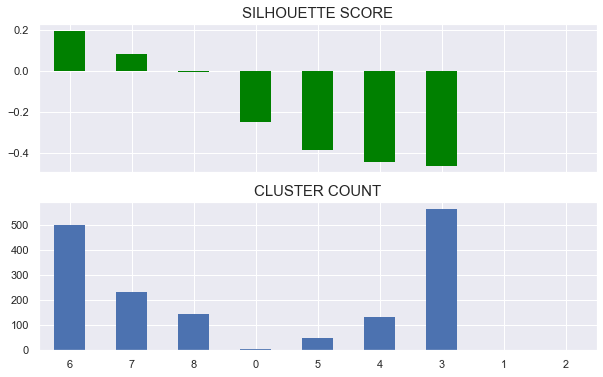

In [269]:
# plot silhouette score and cluster count
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(10, 6))

cluster_scores.loc[:,['sil_score']] \
    .plot(kind='bar', color='green', legend=False, ax=ax0)
ax0.set_title('SILHOUETTE SCORE', fontsize=15)


cluster_scores.loc[:,['cluster_count']] \
    .plot(kind='bar', legend=False, ax=ax1);
ax1.set_title('CLUSTER COUNT', fontsize=15)

plt.xticks(rotation=1);

## Iterations based on best parameters from above

### eps=1, min_sampels=5 

In [ ]:
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

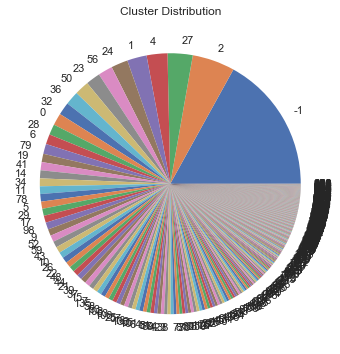

In [153]:
plt.figure(figsize=(6, 6))

clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution')
plt.ylabel('');

With such a large number of clusters I focused on analyzing characteristics within the top 50.

In [166]:
pd.Series(clusters).value_counts()

-1      6517
 2      2024
 27     1193
 4       991
 1       930
        ... 
 496       3
 229       3
 476       3
 442       2
 330       2
Length: 500, dtype: int64

In [155]:
# concat cluster numbers to dataset
df_clusters = pd.concat([df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

In [156]:
# subset dataset based on top 50 clusters by size
df_clusters = df_clusters[df_clusters.cluster.isin(list(pd.Series(clusters).value_counts()[1:51].index))]

In [157]:
# how many citations are included in the 
# top 50 clusters
df_clusters.shape

(21002, 7)

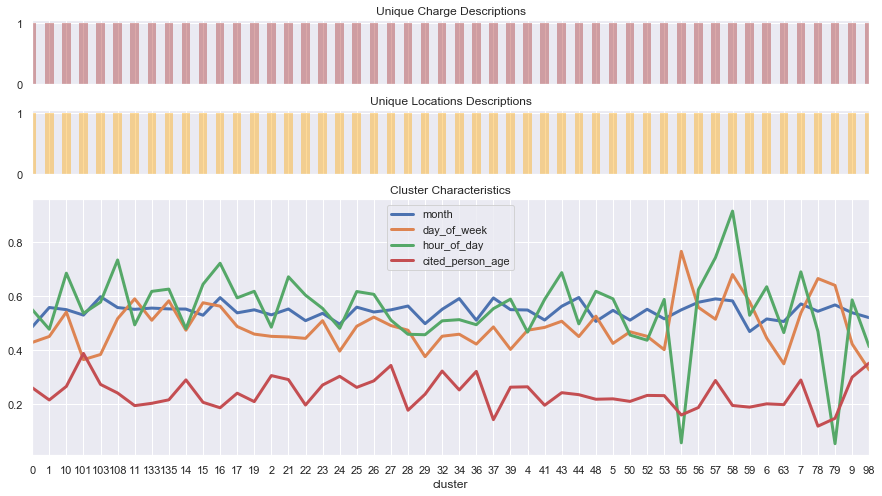

In [766]:
# I had to plot this one with an adjustment to the function
# since my x-axis numbers have uneven breaks
df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_clusters.drop([
    'cluster',
    'beat',
    'charge_description'
], axis=1)))

# rename colums after minmax scaling
df_scaled.columns = df_clusters.drop([
    'cluster',
    'beat',
    'charge_description'
], axis=1).columns

# set plotting parameters
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [1, 1, 4]}, figsize=(15, 8))

# graph cluster counts for categorical features
ax0 = df_clusters.groupby(['cluster'])['charge_description'].agg('nunique').plot(ax=ax0, kind='bar', alpha=.4, title='Unique Charge Descriptions', color='brown')

# graph cluster counts for categorical features
ax1 = df_clusters.groupby(['cluster'])['beat'].agg('nunique').plot(ax=ax1, kind='bar', alpha=.4, title='Unique Locations Descriptions', color='orange')

# graph continuous cluster features
ax2 = pd.concat([df_scaled, df_clusters['cluster'].astype(str).reset_index()], axis=1).groupby(['cluster']).agg(
                                    {'month' : 'mean',
                                    'day_of_week' : 'mean', 
                                    'hour_of_day' : 'mean',
                                    'cited_person_age' : 'mean'}).plot(ax=ax2, title='Cluster Characteristics', linewidth=3);

All the clusters are made up of one categorical variable each (citation type, and location).  
1. Both clusters 55 and 79 show similar characteristics - lower age and hour of the day with later day of the week.  
1. Cluster 101 and 98 represent the oldest people receiving citations, these are happening at a relatively early day of the day.  
1. Cluster 78 represents the youngest people receiving ciations.
1. Cluster 58 represents the latest citations happening in the day, with no pattern in the age or time of day that these citations are issued.

### Clusters 55 and 79
Both of these clusters represent 654 young people who receive DUI citations early in the day on the weekend within beats 5 & 6.

In [798]:
# how many people are included within these clusters
df_clusters[(df_clusters.cluster == 55) |
            (df_clusters.cluster == 79)].shape

(654, 7)

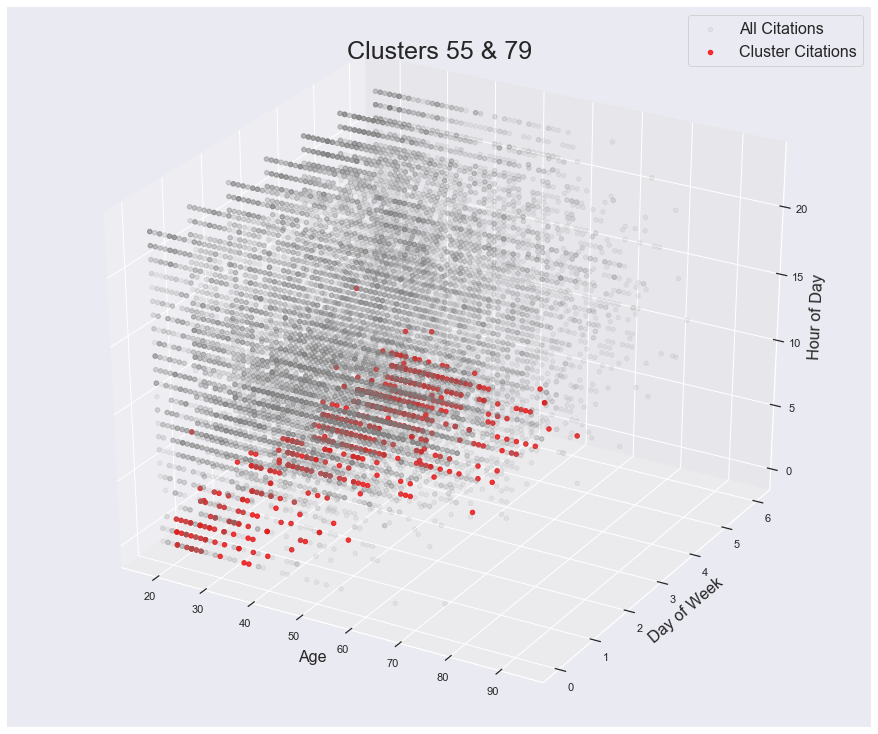

In [302]:
plot_3d(55, 79)

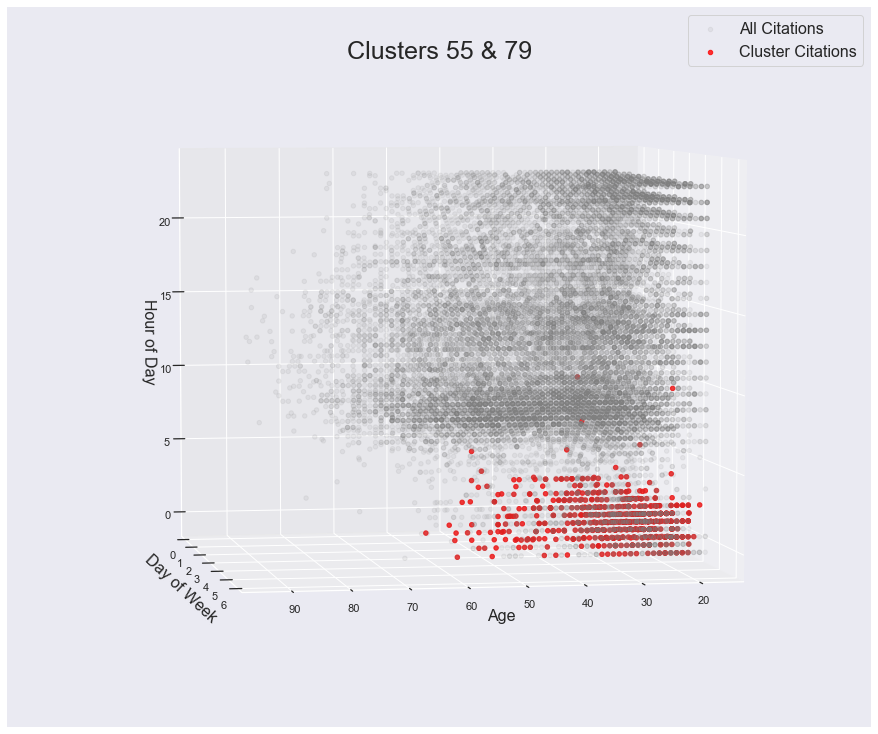

In [314]:
plot_3d(55, 79, 5, 80)

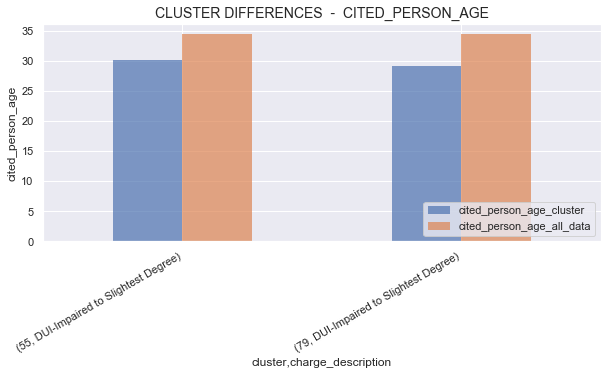

In [776]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 55) |
                            (df_clusters.cluster == 79)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

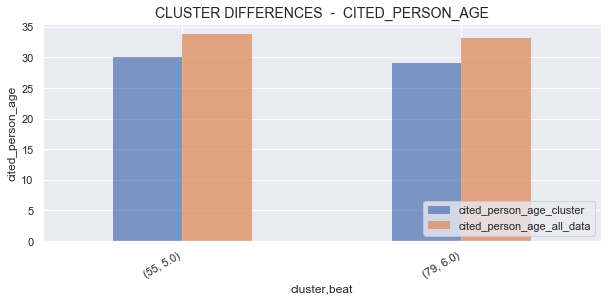

In [777]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'beat'

df_cluster_sub = df_clusters[(df_clusters.cluster == 55) |
                            (df_clusters.cluster == 79)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

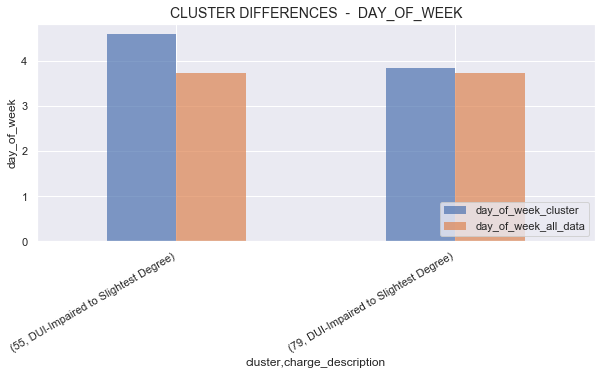

In [781]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'day_of_week'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 55) |
                            (df_clusters.cluster == 79)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

### Cluster 58
This cluster represent the latest citations happening in the day.  With little preference for age, this cluster is made up of 213 people received DUI citations exclusively within beat #6 very late in the evening.

In [801]:
df_clusters[(df_clusters.cluster == 58)].shape

(213, 7)

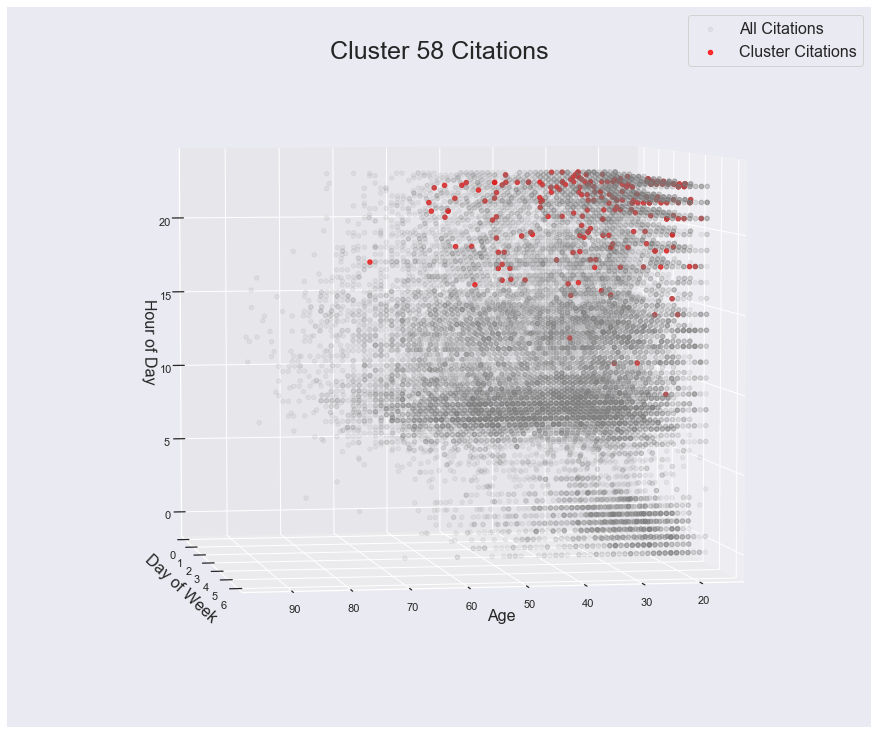

In [283]:
plot_3d(58, None, 80, 5)

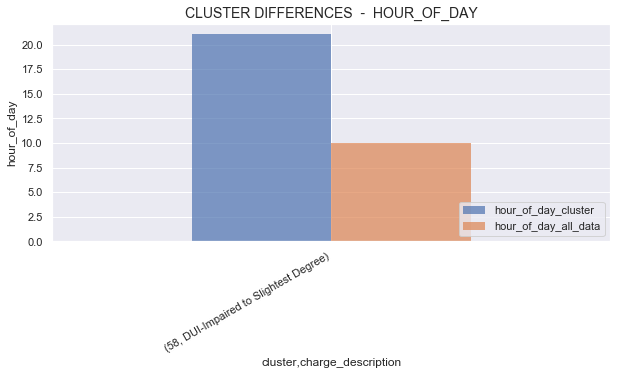

In [796]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'hour_of_day'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 58)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

### Clusters 101 and 98
These clusters represent 509 mostly older people who received citations at a relatively early hour of the day within beat locations 12 & 13.

In [799]:
df_clusters[(df_clusters.cluster == 101) |
            (df_clusters.cluster == 98)].shape

(509, 7)

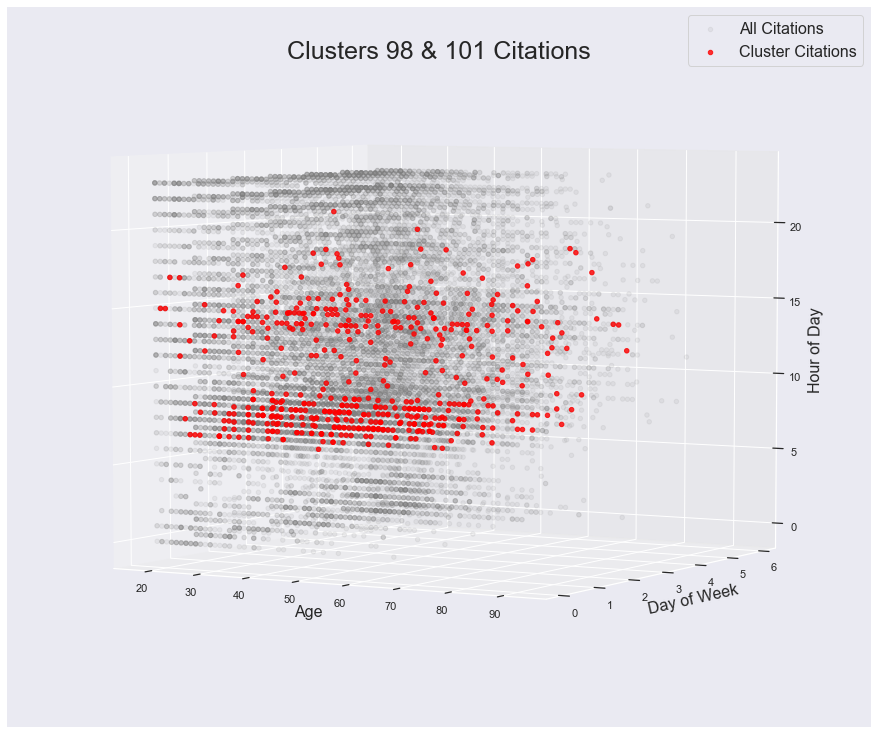

In [293]:
plot_3d(98, 101, None, 5)

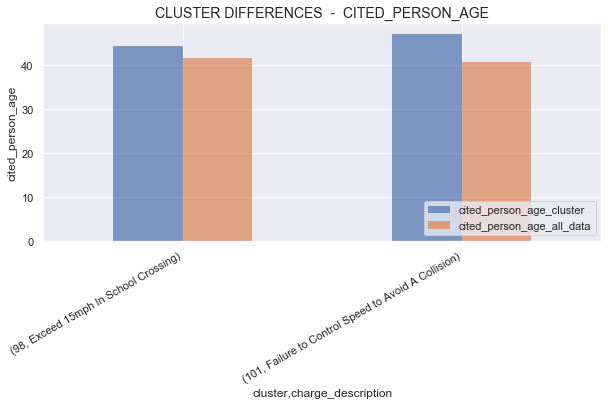

In [783]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 101) |
                            (df_clusters.cluster == 98)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

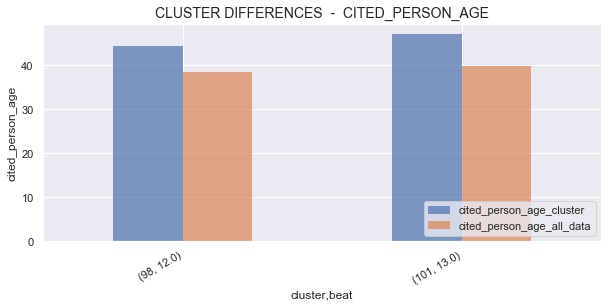

In [784]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'beat'

df_cluster_sub = df_clusters[(df_clusters.cluster == 101) |
                            (df_clusters.cluster == 98)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

### Cluster 78
This cluster represents the youngest mean age within a cluster with 360 people receiving citations for drug paraphernelia within beat 6.  Most of these took place early in the day on the weekend.

In [800]:
df_clusters[(df_clusters.cluster == 78)].shape

(360, 7)

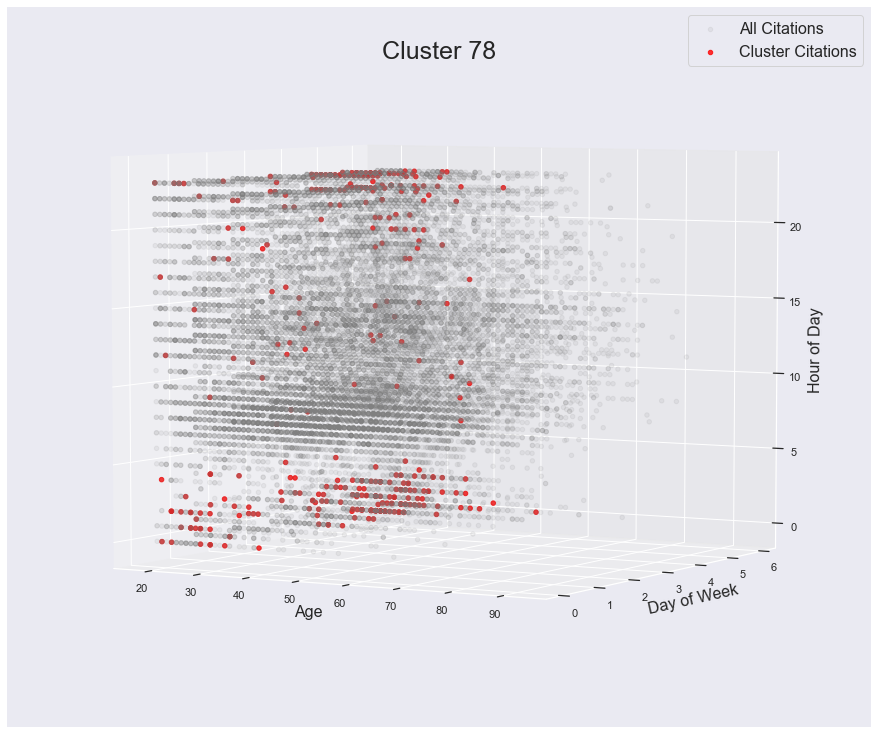

In [318]:
plot_3d(78, None, 5,)

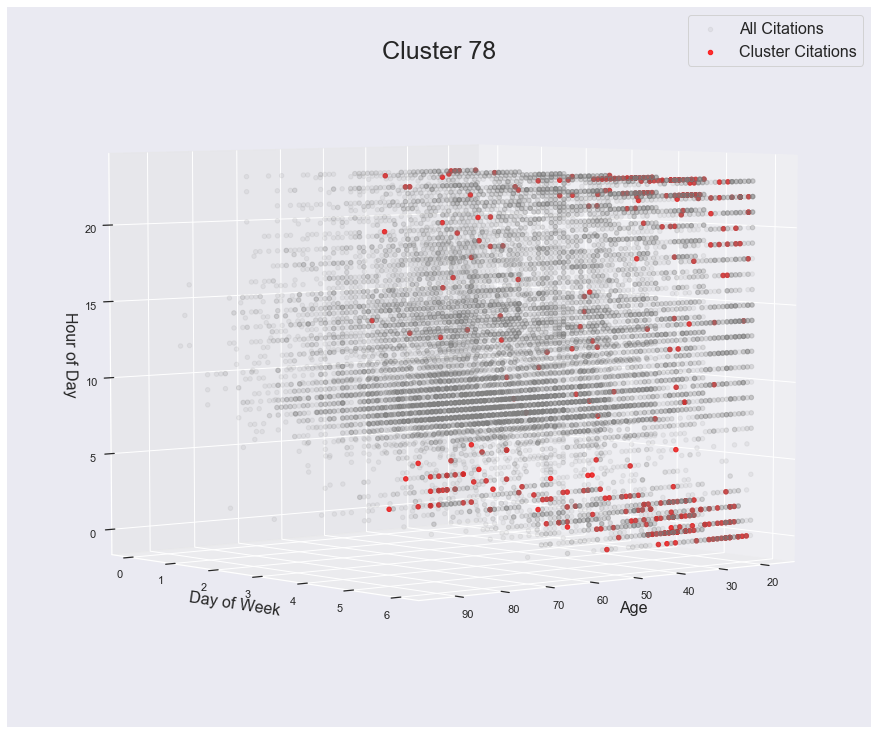

In [321]:
plot_3d(78, None, 5, 50)

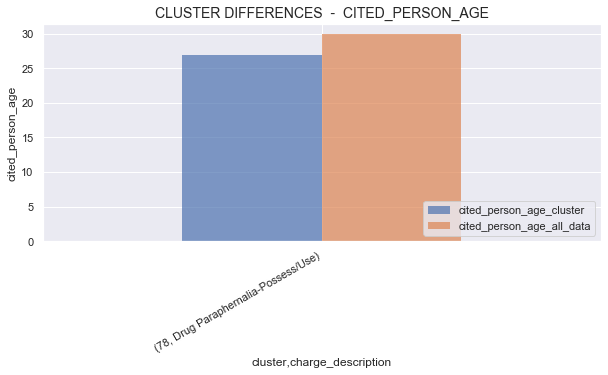

In [789]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 78)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

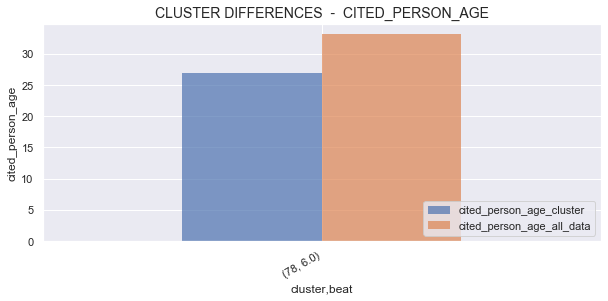

In [791]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'beat'

df_cluster_sub = df_clusters[(df_clusters.cluster == 78)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

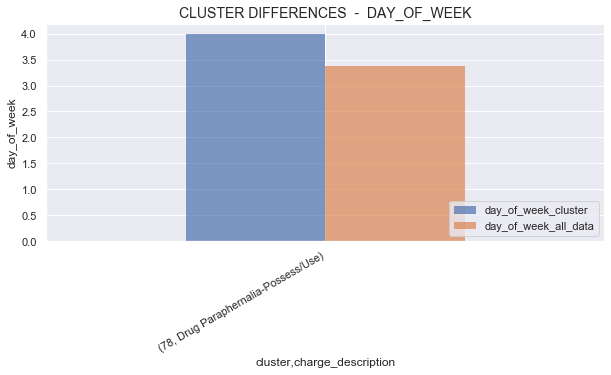

In [792]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'day_of_week'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 78)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

### eps=1, min_sampels=10
Examining the second best parameter configuration based on silhouette coefficient, I increased the min_samples parameter to 10.

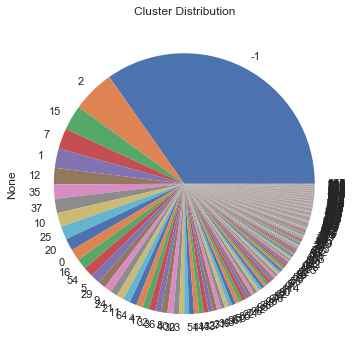

In [655]:
plt.figure(figsize=(6, 6))

dbscan_cluster = DBSCAN(eps=1, min_samples=10)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

Exploring parameters from the next highest silhouette coefficient, a larger share of citations are categorized as not fitting into any cluster.

##### Cluster #17 Summary:
This cluster is made up of 46 citations representing people who receive DUI tickets in beat #6.  All of these tickets took place in the early morning hours on Sunday with an average month of the year of August.  Additionaly, these tickets were received by people at least 10 year younger than average for this citation type.

#### Cluster #7 Summary:
This cluster is quite similar to cluster 17 above.  It is made up of 79 citations representing people younger people who received DUI tickets in beat #6.  The two exceptions from cluster 17 is that the average month of the year is August, and all these citations were received in the early morning on Saturday, rather than Sunday.

### DBSCAN Clustering Summary:
This model did a good job of finding very tight clusters with highly similar characteristics.  This model overwhelmingly clustered based off the categorical features (citation type, and location(beat)).


## CLUSTER USING GMM
<a id='GMM'></a>

GMM Parameters to explore
 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

In [713]:
# find best GMM parameters
sil_score = []
num_components = []
cov_type = []

for n_components in range(10, 31, 5):
    for covariance_type in ['full', 'tied', 'diag', 'spherical']:
    
        # Defining the agglomerative clustering
        gmm_cluster = GaussianMixture(n_components=n_components, covariance_type=covariance_type)

        # Fit model
        clusters = gmm_cluster.fit_predict(X_std)
        
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        
        # record parameter values
        num_components.append(n_components)
        cov_type.append(covariance_type)

In [714]:
# tabulate param results from above
# sort by silhouette score & cluster count
cluster_scores = pd.DataFrame(list(list(zip(sil_score, num_components, cov_type))), 
            columns=['sil_score', 'num_components', 'covariance_type']) \
        .sort_values(by=['sil_score'], ascending=False)

cluster_scores

sil_score  num_components covariance_type
12      0.308              25            full
14      0.302              25            diag
8       0.301              20            full
16      0.286              30            full
15      0.281              25       spherical
18      0.276              30            diag
19      0.267              30       spherical
13      0.256              25            tied
17      0.254              30            tied
9       0.254              20            tied
10      0.243              20            diag
7       0.221              15       spherical
11      0.215              20       spherical
6       0.214              15            diag
5       0.210              15            tied
4       0.206              15            full
1       0.151              10            tied
2       0.148              10            diag
0       0.136              10            full
3       0.032              10       spherical

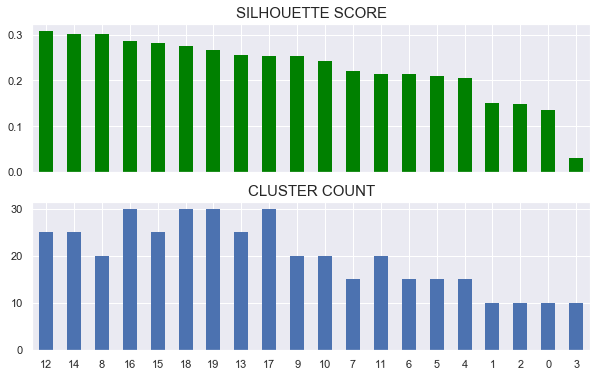

In [715]:
# plot silhouette score and cluster count
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(10, 6))

cluster_scores.loc[:,['sil_score']] \
    .plot(kind='bar', color='green', legend=False, ax=ax0)
ax0.set_title('SILHOUETTE SCORE', fontsize=15)

cluster_scores.loc[:,['num_components']] \
    .plot(kind='bar', legend=False, ax=ax1);
ax1.set_title('CLUSTER COUNT', fontsize=15)

plt.xticks(rotation=1);

The silhouette score at 25 components is significantly higher than that of DBSCAN at .197.

In [335]:
# create model
gmm_cluster = GaussianMixture(n_components=25, covariance_type='full', random_state=123)

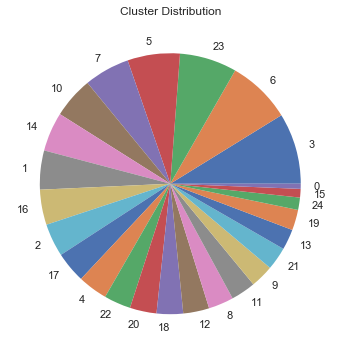

In [336]:
plt.figure(figsize=(6, 6))

clusters = gmm_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution')
plt.ylabel('');

Compared to DBSCAN, the size distribution of GMM is much more distributed.

In [337]:
# join cluster assignment to df
df_clusters = pd.concat([df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

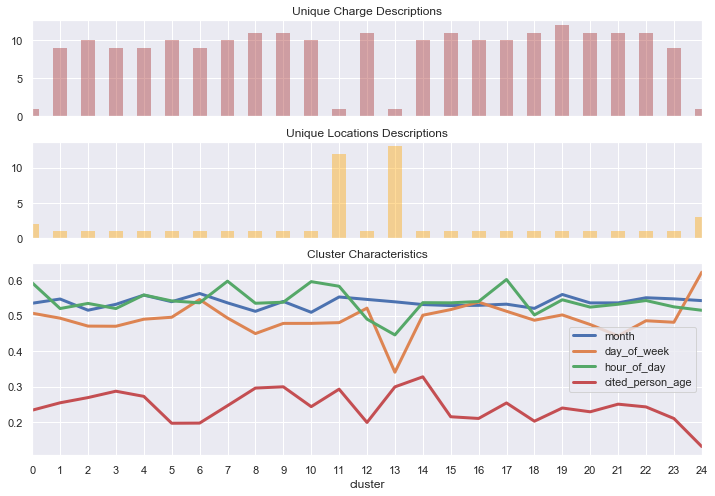

In [338]:
plot_clusters_scaled(df_clusters)

Unlike DBSCAN, GMM has multiple different citation types and locations within the clusters that it grouped.

### EXAMINE SPECIFIC CLUSTERS THAT STAND OUT

### Cluster 13
This cluster is made up of 980 citations for speeding in school zones.  It has a high diversity of beat locations.  This citation also happens mostly early in the morning, and almost exclusively early in the week.

In [356]:
df_clusters[df_clusters.cluster == 13].shape

(980, 7)

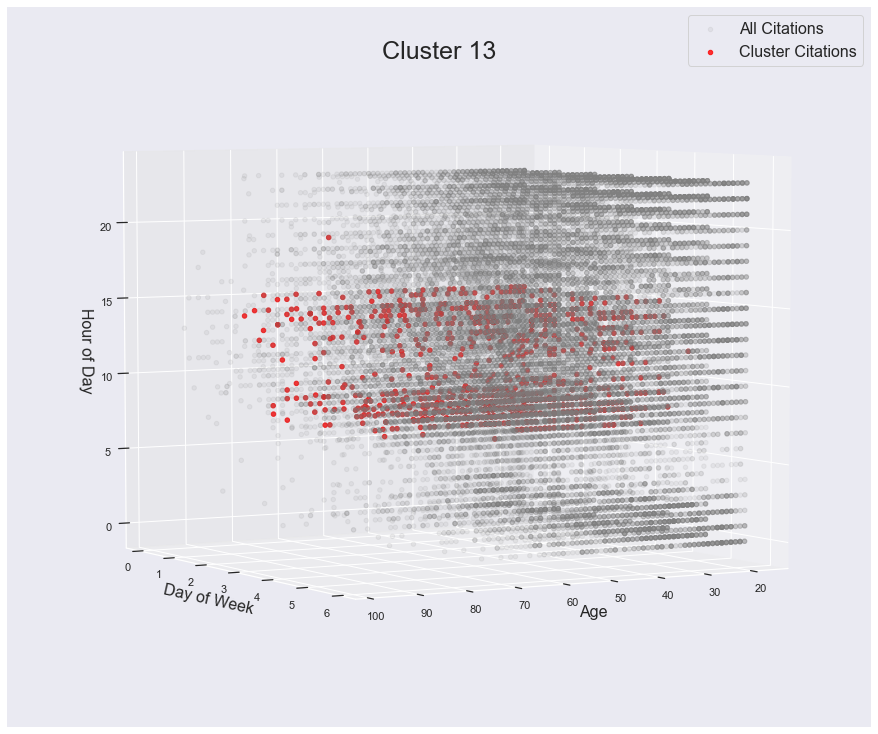

In [355]:
plot_3d(13, None, 5, 60)

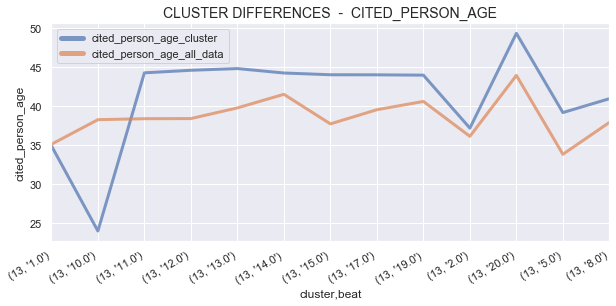

In [357]:
plot_clusters(df, df_clusters, 'beat', 'cited_person_age', 13)

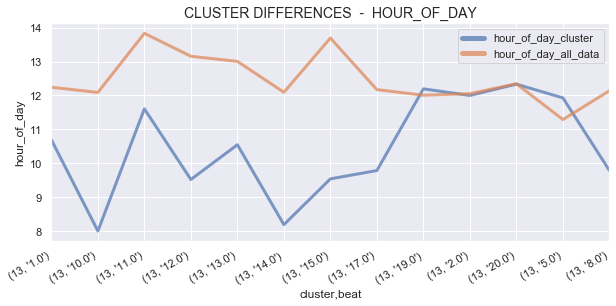

In [358]:
plot_clusters(df, df_clusters, 'beat', 'hour_of_day', 13)

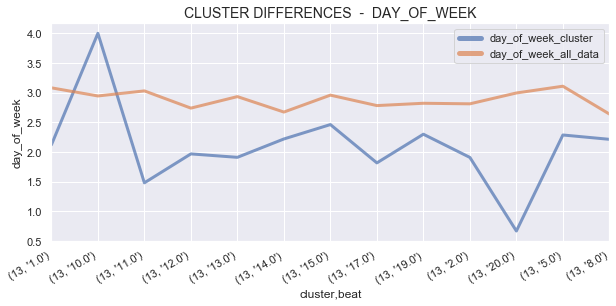

In [364]:
plot_clusters(df, df_clusters, 'beat', 'day_of_week', 13)

### Cluster 24:

This cluster has the lowest mean age and is made up of 586 citations for drug parapharnelia that took place within three different beat locations.  Most of these citations took place later in the week.

In [359]:
df_clusters[df_clusters.cluster == 24].shape

(586, 7)

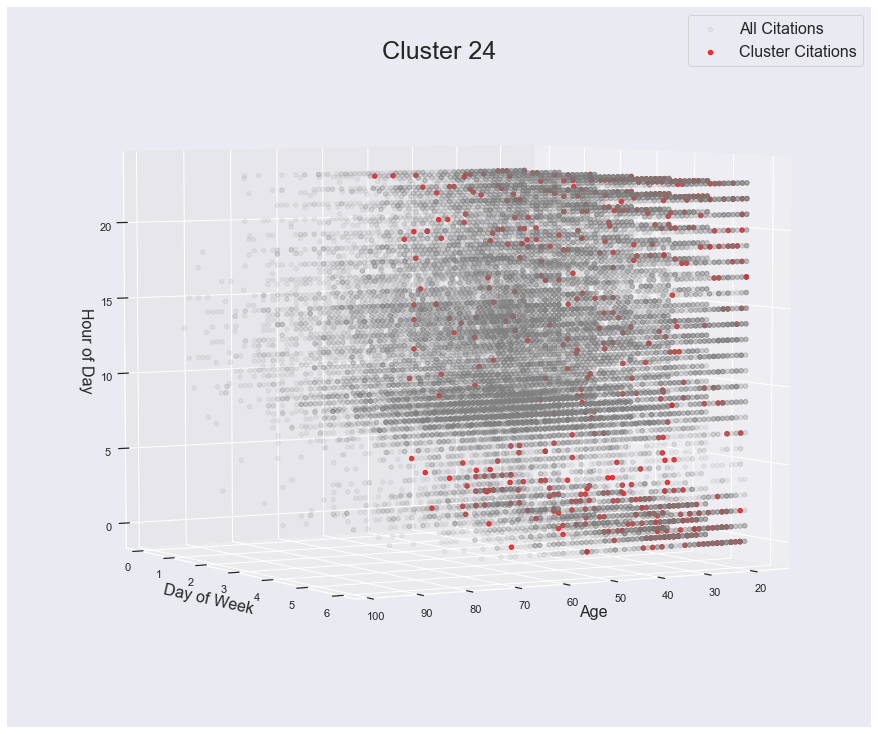

In [373]:
plot_3d(24, None, 5, 60)

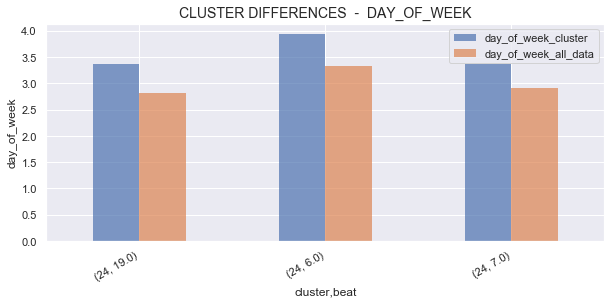

In [369]:
plot_clusters(df, df_clusters, 'beat', 'day_of_week', 24)

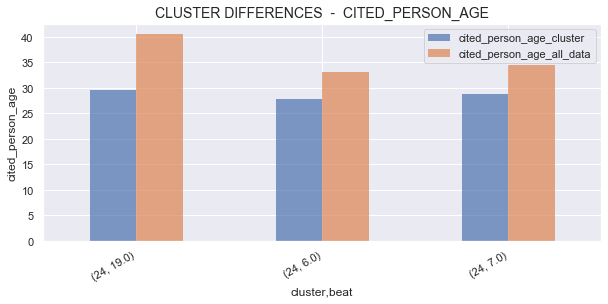

In [374]:
plot_clusters(df, df_clusters, 'beat', 'cited_person_age', 24)

### GMM Clustering Summary:
Although this model classified all citations into one of 25 clusters, the specific characteristics of each cluster were not as strong as those within the smaller DBSCAN clusters.

This model was able to cluster more strongly than DBSCAN using characteristics other than citation type and location.  Whereas all the DBSCAN clusters were made up of onlye one citation type and one location, a number of GMM clusters included a number of unique citation types and locations.

<a id='Hierarchical'></a>
## HIERARCHICAL CLUSTERING

This method forms clusters based hierarchy structures within the data.  Three different linkage methods exist - "ward", "complete", and "average".  Since I'm not expecting clusters of equal sizes, and I'm intereested in tight clusters, I explored the "average" linkage method.

1. **Ward**: The Ward method tends to look for spherical clusters such that the clusters are cohesive inside and differentiated from other groups. In general, this method tends to find clusters of similar size. Note that the Ward method only works with Euclidean distance.
1. **Complete**: The Complete method links clusters using their furthest observations, that is, their most dissimilar data points. Consequently, clusters created using this method tend to be comprised of highly similar observations, making the resulting groups quite compact.
1. **Average**: The Average method links clusters using their centroids. Since this method focuses on centroids and ignoring the boundary points, it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

In [194]:
# plt.figure(figsize=(6, 6))
# agg_cluster = AgglomerativeClustering(linkage='average', 
#                                       affinity='cosine',
#                                       n_clusters=13)

# clusters = agg_cluster.fit_predict(X_std)
# pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

Running the above produced "MemoryError: unable to allocate array data."  So I sampled 10000 citations below.

In [375]:
# select 10000 random rows
rand_index = np.random.choice(X_std.shape[0], size=10000)

In [376]:
# subset the full dataset
X_std_sample = X_std[rand_index,:]

In [381]:
# find best parameters
cluster_count = []
sil_score = []
cluster_param = []

for i in range(2, 50, 4):
    
    # Defining the clustering model
    agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=i)

    # Fit model
    clusters = agg_cluster.fit_predict(X_std_sample)

    # capture cluster count
    cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))

    # capture model fit
    if pd.Series(clusters).nunique() > 1:
        sil_score.append(round(metrics.silhouette_score(X_std_sample, clusters, metric='euclidean'), 3))
    else:
        sil_score.append(np.nan)

    # record parameter values
    cluster_param.append(i)

In [382]:
# tabulate param results from above
# sort by silhouette score & cluster count
cluster_scores = pd.DataFrame(list(list(zip(sil_score, cluster_count, cluster_param))), 
            columns=['sil_score', 'cluster_count', 'cluster_param']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

cluster_scores

sil_score  cluster_count  cluster_param
11      0.266             46             46
7       0.261             30             30
8       0.260             34             34
10      0.254             42             42
9       0.253             38             38
6       0.200             26             26
5       0.138             22             22
4       0.082             18             18
3       0.050             14             14
2       0.018             10             10
1      -0.060              6              6
0      -0.104              2              2

In [401]:
# create clustering model
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=50)

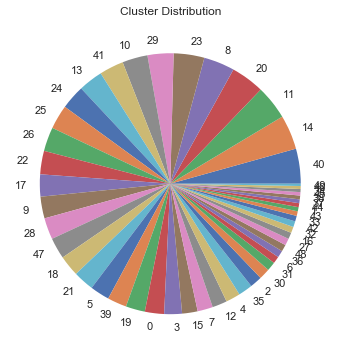

In [402]:
# use model to assign cluster labels
plt.figure(figsize=(6, 6))

clusters = agg_cluster.fit_predict(X_std_sample)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution', )
plt.ylabel('');

In [386]:
# join cluster assignment to df
df_clusters = pd.concat([df.iloc[pd.Series(rand_index)].reset_index(drop=True),
                         pd.Series(clusters).rename('cluster')], 
                        axis=1)

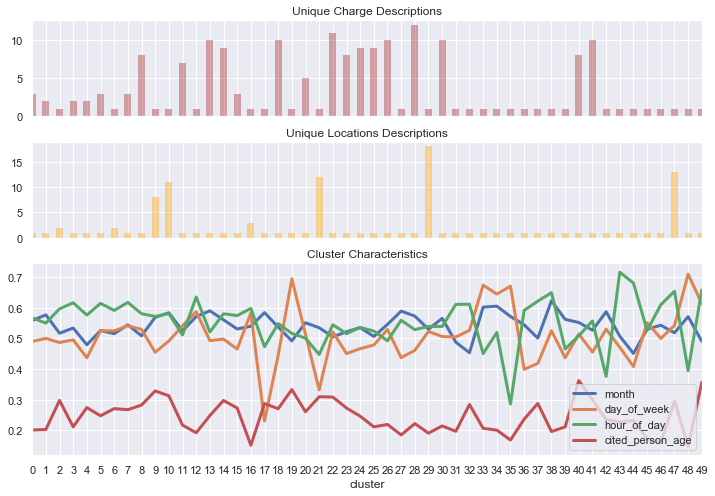

In [387]:
plot_clusters_scaled(df_clusters)

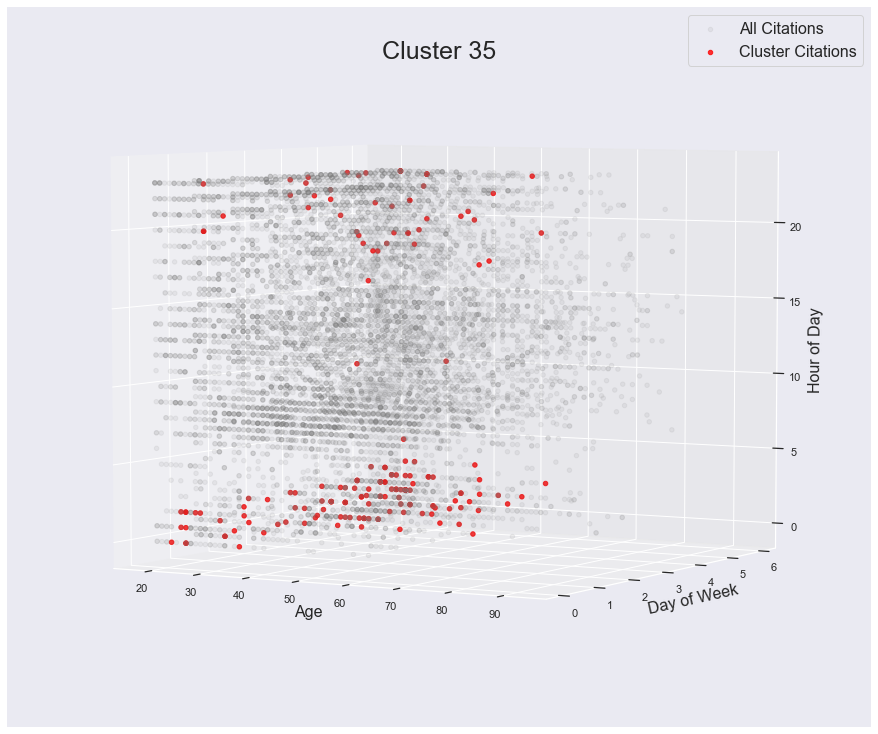

In [394]:
plot_3d(35, None, 5)

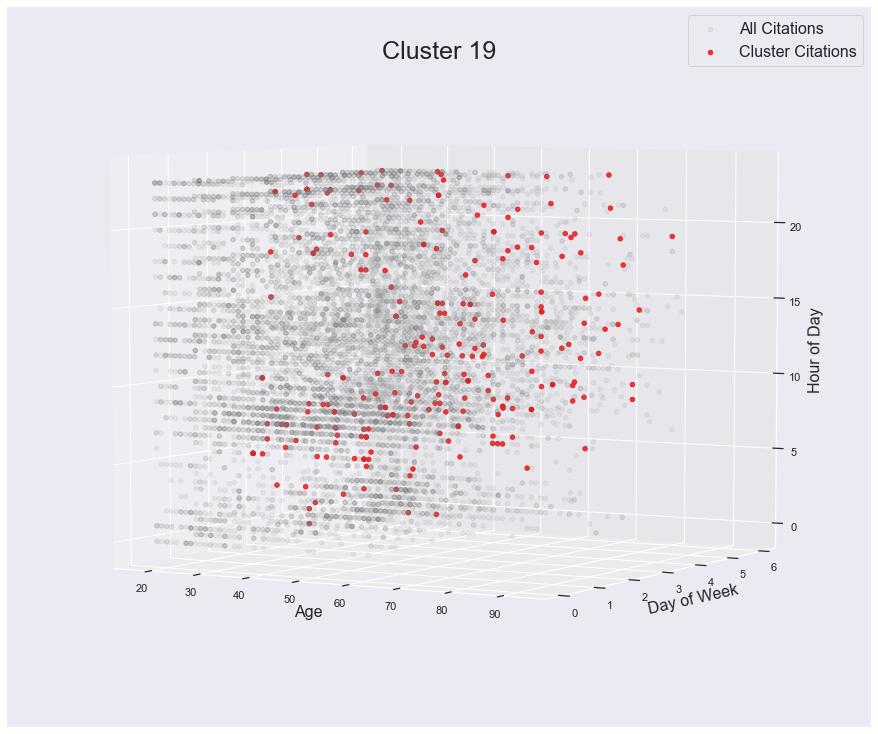

In [390]:
plot_3d(19, None, 5)

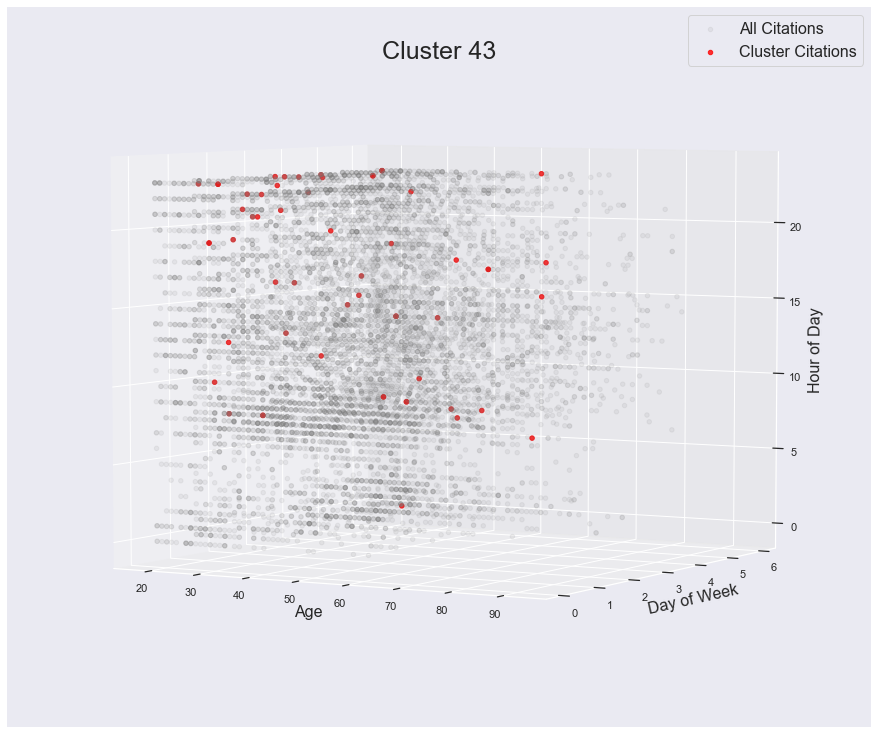

In [395]:
plot_3d(43, None, 5)

### Hierarcical Clustering Summary:

Although the hierarchical model classified the citations into relatively small clusters with a silhouette coefficient slightly higher than DBSCAN, the specific characteristics of each cluster were not as strong as those within the DBSCAN clusters.

<a id='Conclusion'></a>

## CONCLUSION/NEXT STEPS:

### Clustering Method Comparison:
With an end goal of providing specific, actionable recommentations related to which areas of town have the highest concentrations of specific citations being received by people within different demographics DBSCAN was was the clear winner.

The clusters it revealed were not entirely surprising to me.  If I were to focus on cluster groupings for clusters smaller than the top 50, its possible I find find others clusters that have more specific characteristics.

However, within the top 50 DBSCAN clusters, all the clusters were formed around a single citation and location.  Clearly the categories were playing a disproportionate role in the clustering.  

One admirable quality in GMM and Hierarcical clustering is their ability to include more than one citation type and location within each cluster.  With enough tuning it may be possible I could get one of these models to identify clusters as tight as DBSCAN.

### Next Steps:
1. Examine clusters at a much smaller location level by concatenating street name with block number.
1. Join additional datasets to the citation dataset.  More features will likely allow for better clustering.  Specifically, age demographics for specific areas of the city, or the most common business types in various ares of the city.
1. Adjusting Hour_of_Day feature to account for rollover from midnight to early morning hours.